Esta libreta preprocesa automáticamente los datos que ya se encuentran en el directorio recortado en base a los eventos listados en el catálogo.

In [1]:
from pathlib import Path, PurePath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import shutil
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.util.attribdict import AttribDict
from preprocessing_tools import *

In [2]:
directorio_recortado = 'Datos_Trim/'

In [3]:
catalog = 'catalogSSN.dat'

In [4]:
df_catalog = read_catalog(catalog)

In [5]:
#stations_meta = pd.read_csv('station.csv')

In [17]:
remove_response = True

# archivo de configuracion con variables
invs = {}
directorio = 'Respuesta_Instrumento/'
if remove_response:
    net='IG'
    for i, row in df_catalog.iterrows():
        #path = Path(directorio_recortado+row.date_time_id)
        path = directorio_recortado+row.date_time_id+'/'
        
        stations_meta = get_meta_data(path)
        #print(stations_meta)
        date = obspy.UTCDateTime(*list(map(int, row.date_time_id.split('.')[:3])))
        invs[datetime_to_dotformat(date)] = {}
        for sta in stations_meta['kstnm'].unique():
            for file in os.listdir(directorio):
                #print(file)
                #print(file.split('_')[2][:4])
                before = file.split('_')[2]
                after = file.split('_')[3].split('.')[0]
                
                date_before=obspy.UTCDateTime(int(before[:4]), int(before[4:6]), int(before[6:8]))
                date_after=obspy.UTCDateTime(int(after[:4]), int(after[4:6]), int(after[6:8]))
                if re.match('%s_%s_\d+_\d+.*\.RESP'%(sta, net), file) and date_before < date and date_after > date: # Para que solo lea las respuestas de instrumentos actuales
                    with open(directorio+file) as f:
                        #print(file)
                        invs[datetime_to_dotformat(date)][sta] = obspy.read_inventory(f, format='RESP')

# Se dan ciertos errores al usar este objeto
#inventory = obspy.core.inventory.Inventory(sum([inv.networks for inv in list(invs.values())], [])) # Concatena todos los inventarios para unificarlos en uno solo

In [18]:
invs.keys()

dict_keys(['2018.08.12.00.00.00', '2016.07.19.00.00.00', '2016.06.27.00.00.00', '2021.09.08.00.00.00', '2021.03.20.00.00.00', '2018.03.30.00.00.00', '2019.09.30.00.00.00'])

In [21]:
invs['2021.03.20.00.00.00']['IGIG']

Inventory created at 2022-05-26T00:51:21.263527Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (1):
			IG
		Stations (9):
			IG.IGIG () (9x)
		Channels (9):
			IG.IGIG..BHZ, IG.IGIG..BHN, IG.IGIG..BHE, IG.IGIG..HHZ, 
			IG.IGIG..HHN, IG.IGIG..HHE, IG.IGIG..HLZ, IG.IGIG..HLN, 
			IG.IGIG..HLE

In [22]:
rotate_zne = False

pre_filt = [0.004, 0.007, 10, 20]
distances = []
azimuths = []
b_azimuths = []

for index, row in df_catalog.iterrows(): # Para todo evento
    event_dir = directorio_recortado + datetime_to_dotformat(row.date_time)+'/'
    outdir = "%sRT"%event_dir # Output directory
    date= row.date_time_id[:10]+'.00.00.00'
    st = obspy.read(event_dir+'*', format='SAC')
    #print(st)
    
    Path(outdir).mkdir(parents=True,exist_ok=True)
    
    # Remover tendencias de los datos (ej. desfasamientos para alinearse verticalmente con 0 la senal)
    # En el caso de la red submarina no es necesario el paso de quitar la respuesta del instrumento
    st.detrend(type="linear")
    if remove_response:
        for i in range(len(st)):
            st[i].remove_response(inventory=invs[date][st[i].stats.sac.kstnm], pre_filt=pre_filt, output="DISP", zero_mean=True, plot=False)
    st.detrend(type="linear")
    st.detrend(type="demean")

    # Define SAC headers and calculate back-azimtuh for rotation
    origin_time = row.date_time
    depth = row.depth*1000

    #o = []
    #b = []
    stations_meta = get_meta_data(event_dir)
    ev_st_df = link_ev_st(directorio_recortado)
    #print(ev_st_df)
    ev_st_df['distance'] = np.nan
    ev_st_df['azimuth'] = np.nan
    ev_st_df['b_azimuth'] = np.nan

    for i, sta in stations_meta.iterrows(): # Para todo evento y para toda estacion
        # Se asume que el orden de st es el mismo que el de stations_meta en cuanto a estaciones/canales
        
        #meta = inv.get_channel_metadata(tr.id)
        dist, az, baz = gps2dist_azimuth(row.lat,row.lon,sta.stla,sta.stlo) # dist en metros
        #omarker = origin_time - tr.starttime
        omarker = 0
        # Por como son partidos los datos de cada estacion iniciando exactamente en el mismo tiempo que aquel registrado para el evento dentro del catalogo
        # origin_time y starttime son iguales
        
        # baz (back azimuth) es aquel angulo de la estacion con las coordenadas del sismo o evento, asi que lo tendremos que guardar en el trace 

        # Obspy trace headers
        #tr.stats.coordinates = {'latitude':meta['latitude'], 'longitude':meta['longitude']}
        
        q = f"(date_time_id == '{row.date_time_id}') & (st == '{sta.kstnm}')"
        ix = ev_st_df.query(q).index
        cols = ev_st_df.columns
        
        ev_st_df.iloc[ix, cols.get_loc('distance')] = dist/1000 # A kilometros
        ev_st_df.iloc[ix, cols.get_loc('azimuth')] = az
        ev_st_df.iloc[ix, cols.get_loc('b_azimuth')] = baz
        
        #o.append(0)
        #b.append(-1*omarker)
        
        #print(sta.kstnm, st[i].stats.sac.kstnm)
        # Hay que guardar otros atributos como starttime y endtime porque al guardar se borran los datos anteriores
        st[i].stats.back_azimuth = baz
        st[i].stats.distance = dist # En metros
        #st[i].stats.starttime = row.date_time
        #st[i].stats.endtime = row
        
        # Solo los datos guardados sobre el atributo sac quedaran grabados en el archivo SAC
        #st[i].stats.sac.az = az
        sacd = AttribDict()
        sacd.stla = sta.stla
        sacd.stlo = sta.stlo
        sacd.stel = sta.stel
        sacd.evla = row.lat
        sacd.evlo = row.lon
        sacd.evdp = depth # in meters
        sacd.az = az
        sacd.baz = baz
        sacd.dist = dist/1000 # A kilometros
        sacd.o = 0
        sacd.b = -1*omarker
        st[i].stats.sac = sacd
        
        #distances.append(dist)
        #azimuths.append(az)
        #b_azimuths.append(baz)
        
    #for sta in stations_meta['kstnm'].unique():
    #    traces = st.select(station=sta)
    #    traces.rotate(method="NE->RT")
    
    # No es necesario rotar a ZNE en el caso de los datos de la red submarina ya que los tres componentes o canales ya vienen orientados en norte, este y la vertical
    if rotate_zne:
        # Los canales del SSN ya estan orientados en ZNE
        # Forzosamente se requiere proporcionar un Stream con los tres canales en conjunto a rotar, a diferencia de remove_response
        st_sta = obspy.Stream()
        rotated_sts = []
        for i, sta in stations_meta.iterrows():
            if i%3 == 0:
                if i != 0:
                    #print(st_sta)
                    #print(invs[sta.kstnm])
                    st_sta._rotate_to_zne(invs[sta.kstnm],components=("ZNE","Z12"))
                    rotated_sts.append(st_sta)
                st_sta = obspy.Stream()
            st_sta.append(st[i])
        st = obspy.Stream(sum(rotated_sts, [])) # Unificar en un solo stream y sustituir
    
    # Todas las estaciones submarinas ya vienen con tres componentes, asi que tampoco es necesario verificarlo
    # Se rota a RT para trabajar mas facilmente la distancia y el angulo con cada sismo
    st.rotate(method="NE->RT")
    
    for tr in st:
        tr.write("%s/%s"%(outdir,tr.id),format="SAC")
    
    #ev_st_df['distance'] = distances
    #ev_st_df['azimuth'] = azimuths
    #ev_st_df['b_azimuth'] = b_azimuths

    ev_st_df.to_csv('ev_st_%s.csv'%(row.date_time_id))

#tr_df['o'] = o
#tr_df['b'] = b

In [23]:
#max_dist = 300
#min_dist = 50
for i, row in df_catalog.iterrows():
    evid = row.date_time_id
    evdir = directorio_recortado + evid + '/'
    ev_st_df = pd.read_csv('ev_st_%s.csv'%(evid))
    
    if row.mag < 4.0:
        min_dist = 30
        max_dist = 300
    elif 4.0 <= row.mag < 5.0:
        min_dist = 30
        max_dist = 450
    elif 5.0 <= row.mag < 6.5:
        min_dist = 100
        max_dist = 600
    elif 6.5 <= row.mag < 7.5:
        min_dist = 400
        max_dist = 995
    elif 7.5 <= row.mag:
        min_dist = 500
        max_dist = 1500
    
    remove_df = ev_st_df.loc[(ev_st_df['distance'] <= min_dist) | (ev_st_df['distance'] >= max_dist)]
    
    remove_st = remove_df['st'].unique()
    
    for st in remove_st:
        st_files = glob.glob(evdir+'**/*%s*'%(st), recursive=True)
        for st_file in st_files:
            os.remove(st_file)
            
    ev_st_df.drop(remove_df.index, inplace=True)
    ev_st_df.to_csv('ev_st_%s.csv'%(evid))

In [24]:
ev_st_df.loc[ev_st_df['st'] == 'PNIG']

,Unnamed: 0,starttime,endtime,sampling_rate,st,ch,date_time_id,distance,azimuth,b_azimuth
60,60,2021-09-08T01:47:43.000000Z,2021-09-08T01:53:53.000000Z,100.0,PNIG,HHN,2021.09.08.01.47.53,NaN,NaN,NaN
88,88,2021-09-08T01:47:43.000000Z,2021-09-08T01:53:53.000000Z,100.0,PNIG,HHE,2021.09.08.01.47.53,NaN,NaN,NaN
89,89,2021-09-08T01:47:43.000000Z,2021-09-08T01:53:53.000000Z,100.0,PNIG,HHZ,2021.09.08.01.47.53,NaN,NaN,NaN
209,209,2021-03-20T03:06:25.000000Z,2021-03-20T03:12:35.000000Z,100.0,PNIG,HHN,2021.03.20.03.06.35,NaN,NaN,NaN
238,238,2021-03-20T03:06:25.000000Z,2021-03-20T03:12:35.000000Z,100.0,PNIG,HHE,2021.03.20.03.06.35,NaN,NaN,NaN
239,239,2021-03-20T03:06:25.000000Z,2021-03-20T03:12:35.000000Z,100.0,PNIG,HHZ,2021.03.20.03.06.35,NaN,NaN,NaN
354,354,2016-07-19T13:42:36.000000Z,2016-07-19T13:48:46.000000Z,100.0,PNIG,HHN,2016.07.19.13.42.46,NaN,NaN,NaN
388,388,2016-07-19T13:42:36.000000Z,2016-07-19T13:48:46.000000Z,100.0,PNIG,HHE,2016.07.19.13.42.46,NaN,NaN,NaN
389,389,2016-07-19T13:42:36.000000Z,2016-07-19T13:48:46.000000Z,100.0,PNIG,HHZ,2016.07.19.13.42.46,NaN,NaN,NaN
513,513,2018-03-30T15:07:51.000000Z,2018-03-30T15:14:01.000000Z,100.0,PNIG,HHN,2018.03.30.15.08.01,NaN,NaN,NaN


In [35]:
evid_Guerrero = '2016.07.19.13.42.46'
evid_Oaxaca = '2016.06.27.20.50.35'

st = obspy.read(directorio_recortado+'2021.09.08.01.47.53'+'/RT/*')

In [36]:
st

48 Trace(s) in Stream:

IG.AAIG..HHR | 2021-09-08T01:47:43.000000Z - 2021-09-08T01:53:53.000000Z | 100.0 Hz, 37001 samples
...
(46 other traces)
...
IG.TUIG..HHZ | 2021-09-08T01:47:43.000000Z - 2021-09-08T01:53:53.000000Z | 100.0 Hz, 37001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [37]:
st[3].stats

         network: IG
         station: ANIG
        location: 
         channel: HHR
       starttime: 2021-09-08T01:47:43.000000Z
         endtime: 2021-09-08T01:53:53.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 37001
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.0099999998, 'depmin': -0.0023472693, 'depmax': 0.0023789525, 'b': 0.0, 'e': 370.0, 'o': 0.0, 'stla': 21.053801, 'stlo': -104.5207, 'stel': 1015.0, 'evla': 17.030001, 'evlo': -99.760002, 'evdp': 21800.0, 'dist': 670.35126, 'az': 312.38562, 'baz': 130.83064, 'depmen': 1.8753261e-21, 'nzyear': 2021, 'nzjday': 251, 'nzhour': 1, 'nzmin': 47, 'nzsec': 43, 'nzmsec': 0, 'nvhdr': 6, 'npts': 37001, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'kstnm': 'ANIG', 'kcmpnm': 'HHR', 'knetwk': 'IG'})

In [38]:
#print(st[0].stats.sac)

In [39]:
#st[0].data

Podria ser que ya vengan filtrados los datos

In [40]:
#st[0].stats.starttime

In [41]:
#st.plot()

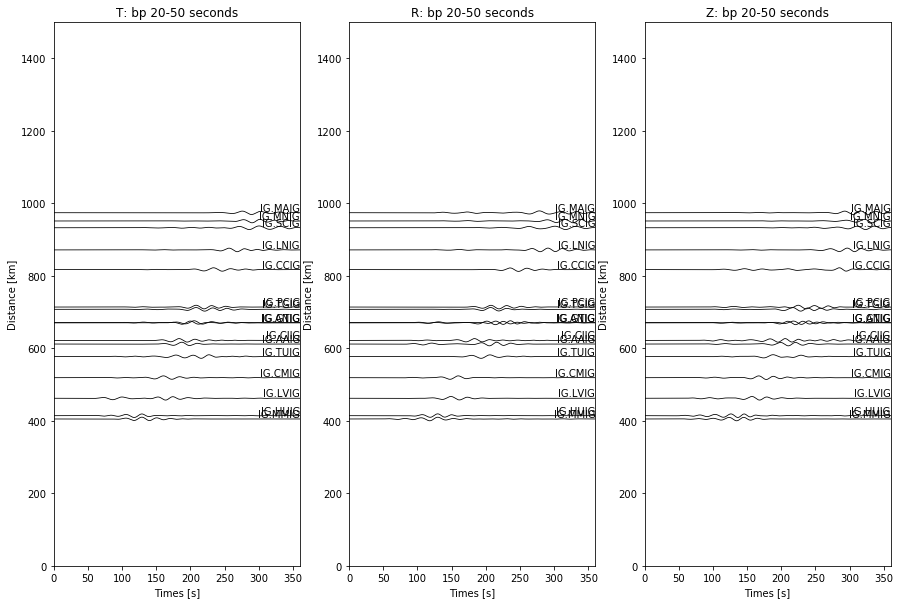

In [46]:
freqmin = 0.02
freqmax = 0.05

# Rango de frecuencias establecido por Dahal y Ebel
#freqmin = 1.5
#freqmax = 2.5

corners = 3
st_filt = st.copy()

st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
st_filt.taper(max_percentage=0.05)

xmin = 0
xmax = 360 # El tiempo de grabacion
ymin = 0
ymax = 1500
scale = 5
fig, axes = plt.subplots(1,3,figsize=(15,10))
components_sub = ("T","R","U")
components_SSN = ("T","R","Z")
for component, ax in zip(components_SSN,axes):
    for tr in st_filt.select(component=component):
        times = tr.times()
        tr.data /= max(abs(tr.data))
        tr.data *= scale
        ax.plot(times,tr.data+tr.stats.sac.dist,color="black",linewidth=0.8)
        ax.text(xmax,tr.stats.sac.dist,"%s.%s"%(tr.stats.network,tr.stats.station),va="bottom",ha="right")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Times [s]")
    ax.set_ylabel("Distance [km]")
    ax.set_title("%s: bp %.0f-%.0f seconds"%(component,1/freqmax,1/freqmin))

# Sección Pruebas

## Continuar con el resto de pasos para el cálculo de mecanismos ahora que ya se ha incorporado al flujo de preprocesamiento los datos del SSN

Problema con calculo de distancias ya que la amplitud no es consistente? 

Comparar con los sismogramas del SSN para el sismo de mayor magnitud (5.2) para averiguar diferencia o potencial pre filtrado y continuar con calculo de mecanismos focales

Usar el programa compartido para descargar con los comandos compartidos en DropBox. Ver video sobre respuesta de instrumentación

Hacer primero para estaciones de Tierra removiendo repuesta del instrumento

Todo esto para validar el método y descubrir posible influencia de prefiltrado

In [17]:
sismo_SSN = obspy.read('Datos_SSN/*.sac')

Exception: No file matching file pattern: Datos_SSN/*.sac

In [ ]:
sismo_SSN[0].stats

Como estas estaciones no están orientadas en componentes N, E y U, sería necesario obtener el inventario de estaciones para poder usar las funcionees de Obspy para la rotación a los componentes R, T y U.

Pero en cuanto a quitar la respuesta del instrumento, quizá no sea necesario el inventario, simplemente se tratará de una serie de filtrados de frecuencia de acuerdo a los registros de variación de amplitud respecto a la frecuencia. Se quiere usar el rango de frecuencias que muestre una tendencia de amplitud lo más horizontal posible para cada estación. En la carpeta de respuestas para las estaciones del SSN a trabajar, los archivos tienen en su nombre un año que indica en qué momento dejó de usarse el sensor, así que solo debe usarse la primera respuesta que indique una fecha posterior a 2018, ya que estos habrán estado en uso durante el tiempo de estudio de este sismo de mayor magnitud. Fechas posteriores a la primera respuesta posterior a 2018 no registraron la señal del sismo de interés ya que fueron usados años más tarde

Una vez que se tenga filtrada la señal, simplemente se tendrá que multiplicar por el factor de amplitud registrado en la respuesta para obtener el verdadero efecto del suelo.

MGIG y CAIG no pudieron descargarse para el sismo de mayor magnitud con ninguno de los comandos:

WIN IG MGIG HH_ 2018/08/12,14:42:09 +300s

WIN IG MGIG % 2018/08/12,14:42:09 +300s

WIN IG CAIG HH_ 2018/08/12,14:42:09 +300s

WIN IG CAIG % 2018/08/12,14:42:09 +300s

Además, Obspy sí tiene una forma para quitar la respuesta del instrumento en base a archivos .RESP que se leen igual que un inventario de estaciones:

pre_filt = [0.01, 0.05, 8, 10]

inv = obspy.read_inventory('./OXIG.RESP')

sismo.remove_response(inventory=inv, output="DISP",zero_mean=True, plot=True, taper=True)

In [ ]:
stations = ['CRIG', 'DAIG', 'MEIG', 'TLIG']
datetime = '20180812144209'
net = 'IG'

In [ ]:
sismos = {}
for sta in stations:
    sismos[sta] = obspy.read('Datos_SSN/%s.%s.%s.*'%(datetime, net, sta))

In [ ]:
sismos['CRIG'].plot()
plt.show()

In [ ]:
sta = 'DAIG'
directorio = 'Respuesta_Instrumento/'
for file in os.listdir(directorio):
    if re.match('%s_%s_\d+_2100.*\.RESP'%(sta, net), file): # Para que solo lea las respuestas de instrumentos actuales
        with open(directorio+file) as f:
            inv = obspy.read_inventory(f)
            
sismos[sta].remove_response(inventory=inv, output="DISP",zero_mean=True, plot=True, taper=True)
sismos[sta].plot()
plt.show()

Estas respuestas parecen estar bien, pero comparar aún así con SAC por curiosidad

Y finalmente, incorporar ahora sí estos datos al resto del código para rotar y continuar con el resto del proceso para el cálculo de mecanismos focales